In [1]:
!python3 --version

Python 3.10.8


In [2]:
import torch
import torch.nn as nn
from torch_geometric import *
from torch_geometric.data import *
from torch_geometric.utils.convert import *
import matplotlib.pyplot as plt
import networkx as nx
import scipy
import scipy.io

In [3]:
import numpy as np

In [4]:
import utils

In [5]:
import cdiscriminator as D

In [6]:
import datahelper as DH

In [7]:
TheDataset = DH.QM9Data()

Enter the path where you want to download the QM9 dataset: 


In [8]:
graph, matrix = TheDataset[18456]

Number of nodes: 13
Number of edges: 30
Average node degree: 2.31
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [9]:
from_networkx(graph)

Data(edge_index=[2, 30], num_nodes=13)

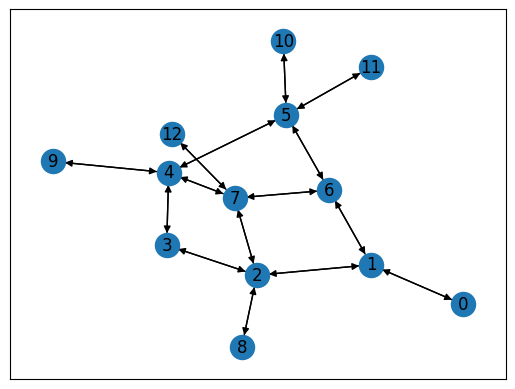

In [10]:
nx.draw_networkx(graph, pos=None, arrows=True, with_labels=True)

In [11]:
graph = nx.to_numpy_array(graph)

In [12]:
def IOGraph(graph):
    graph[graph!=0] = 1.0
    graph_nx = nx.from_numpy_array(graph)
    graph_sparse = scipy.sparse.csr_matrix(graph)
    n_edges = graph.sum()
    print(f"This graph has {n_edges} edges!")
    return graph, graph_nx, graph_sparse

In [13]:
g, gnx, gsp = IOGraph(graph)

This graph has 30.0 edges!


In [14]:
import rdkit.Chem as Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Descriptors import ExactMolWt
from rdkit.Chem.Lipinski import NumHAcceptors, NumHDonors
from rdkit.Chem.Crippen import MolLogP

In [16]:
import qgenerator as QG

In [17]:
import trainer as T

In [26]:
trainer = T.Trainer(gsp, len(g), max_iterations=100, rw_len=2, batch_size=len(g), H_gen=len(g), H_disc=len(g), H_inp=len(g), z_dim=len(g), lr=0.0003, n_critic=3, gp_weight=10.0, betas=(.5, .9),
                    l2_penalty_disc=5e-5, l2_penalty_gen=1e-7, temp_start=5.0, temp_decay=1-5e-5, min_temp=0.5,  val_share=0.1, test_share=0.05, seed=69420, set_ops=False, undir=True)

  (0, 1)	1.0
  (1, 0)	1.0
  (1, 2)	1.0
  (1, 6)	1.0
  (2, 1)	1.0
  (2, 3)	1.0
  (2, 7)	1.0
  (2, 8)	1.0
  (3, 2)	1.0
  (3, 4)	1.0
  (4, 3)	1.0
  (4, 5)	1.0
  (4, 7)	1.0
  (4, 9)	1.0
  (5, 4)	1.0
  (5, 6)	1.0
  (5, 10)	1.0
  (5, 11)	1.0
  (6, 1)	1.0
  (6, 5)	1.0
  (6, 7)	1.0
  (7, 2)	1.0
  (7, 4)	1.0
  (7, 6)	1.0
  (7, 12)	1.0
  (8, 2)	1.0
  (9, 4)	1.0
  (10, 5)	1.0
  (11, 5)	1.0
  (12, 7)	1.0
This graph is connected
idx_ones looks like [0 1 2]
s_train is equal to 0
test_ones looks like [[6 5]
 [7 4]
 [7 6]]
N_test is 3.
test_zeros looks like [[ 7  0]
 [10  6]
 [ 9  1]] with length 3.


**** Using VAL criterion for early stopping with max patience of: 5****
iteration: 1      critic: 6.123354      gen -0.015774
1
samples:[[10  6]
 [ 6  4]]
roc: 0.2500   avp: 0.5000   eo: 0.0000
Took 1.9608906984329224 minutes so far..
iteration: 11      critic: 4.783494      gen -0.031158
1
samples:[[5 8]
 [8 4]]
roc: 0.5000   avp: 0.5000   eo: 0.0000
Took 3.871711877981822 minutes so far..
iteration: 21      critic: 3.386518      gen -0.051192


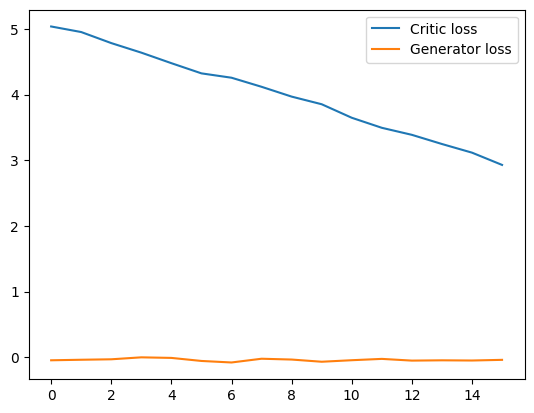

1
samples:[[1 9]
 [4 9]]
roc: 0.5000   avp: 0.5000   eo: 0.0667
Took 5.803693246841431 minutes so far..
iteration: 31      critic: 2.024660      gen -0.083437
1
samples:[[ 7 10]
 [ 7  6]]
roc: 0.5000   avp: 0.5000   eo: 0.0667
Took 7.816349200407664 minutes so far..
iteration: 41      critic: 1.001760      gen -0.174886
1
samples:[[3 3]
 [5 6]]
roc: 0.7500   avp: 0.7500   eo: 0.0667
Took 9.825419914722442 minutes so far..


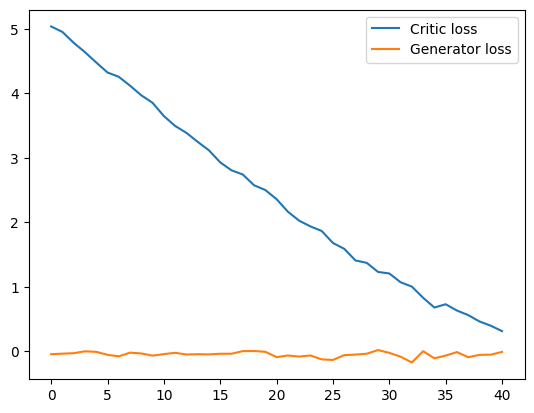

iteration: 51      critic: 0.150998      gen -0.135803
1
samples:[[12  0]
 [ 2  0]]
roc: 0.5000   avp: 0.5000   eo: 0.0000
Took 11.770006748040517 minutes so far..
iteration: 61      critic: -0.055193      gen -0.202430
1
samples:[[4 0]
 [4 0]]
roc: 0.5000   avp: 0.5000   eo: 0.0000
Took 13.751569247245788 minutes so far..
iteration: 71      critic: 0.028466      gen -0.117310


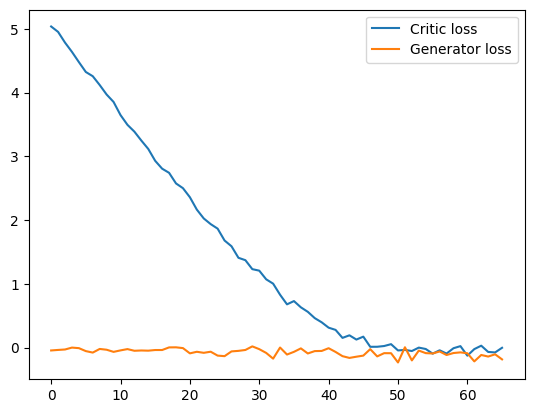

1
samples:[[2 6]
 [7 1]]
roc: 0.5000   avp: 0.5000   eo: 0.0000
Took 15.695157448450724 minutes so far..
iteration: 81      critic: -0.032784      gen -0.032313
1
samples:[[ 9 11]
 [10  6]]
roc: 0.2500   avp: 0.5000   eo: 0.0000
Took 17.67660411596298 minutes so far..
iteration: 91      critic: -0.104818      gen -0.105116
1
samples:[[10  1]
 [12  2]]
roc: 0.5000   avp: 0.5000   eo: 0.0000
finished after 99 iterations
Took 19.593998984495798 minutes so far..


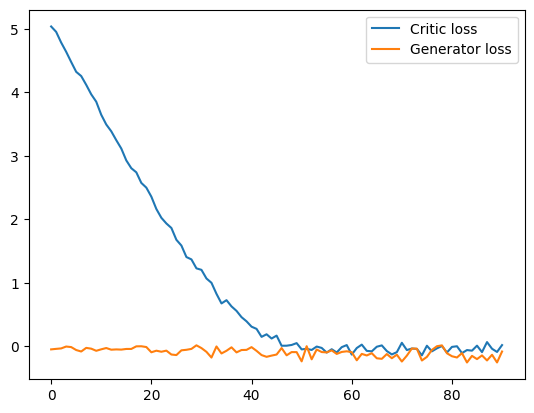

In [27]:
trainer.train(create_graph_every=10, plot_graph_every=25, num_samples_graph=100, stopping_criterion='val')

In [28]:
def create_fake(num_samples, tmp=100):
    samples = []
    num_iterations = num_samples//100+1
    for _ in range(num_iterations):
        samples.append(trainer.generator.sample_discrete(num_samples//100, trainer.device))
    samples = np.vstack(samples)
    print(samples)
    gr = utils.score_matrix_from_random_walks(samples, trainer.N)
    gr = gr.tocsr()
    return gr

In [75]:
grrrr = create_fake(500)

[[10  7]
 [ 3  2]
 [10  8]
 [ 1 11]
 [ 7  4]
 [ 2 12]
 [ 4  9]
 [ 0 11]
 [ 4  0]
 [ 6  1]
 [ 8 11]
 [ 4  1]
 [ 0  9]
 [ 0  7]
 [ 3  6]
 [12  3]
 [ 5  2]
 [ 9  5]
 [11 11]
 [ 2 11]
 [ 3  6]
 [ 5  7]
 [ 6  2]
 [11  1]
 [11  7]
 [12  6]
 [ 9  7]
 [ 1 10]
 [ 5  4]
 [ 8  4]]


In [76]:
graph_sampled = utils.graph_from_scores(grrrr, graph.sum())

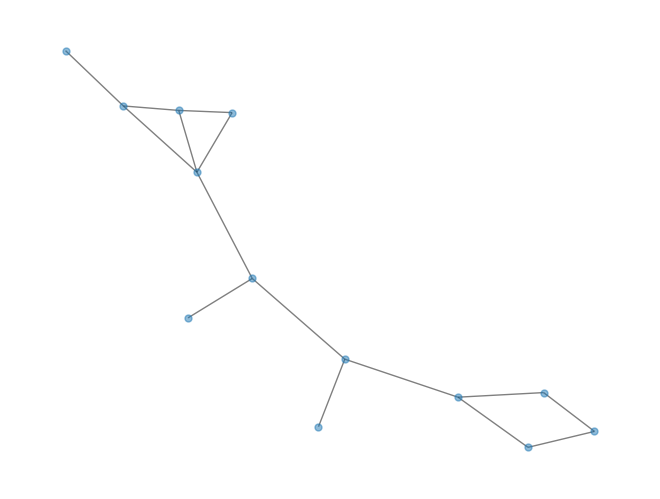

In [77]:
graph_nx_sampled = nx.from_numpy_array(graph_sampled)
nx.draw(graph_nx_sampled, node_size=25, alpha=0.5)

In [80]:
class MethFactory(object):
    def __init__(self, mol, graph, folder, draw=True, Fluorine=False):
        self.mol = nx.from_numpy_array(mol)
        #if draw: nx.draw(self.mol)
        self.atom_labels = {}
        self.valence = {
            #0 : "",
            1 : "H", #Hydrogen
            2 : "O", #Oxygen
            3 : "N", #Nitrogen
            4 : "C" #Carbon
        }
        if Fluorine: self.valence[1] = "F"
        for vertex, degree in self.mol.degree():
            if degree == 0: continue
            self.atom_labels[vertex] = self.valence[degree]
        if draw:
            reds = [x for x in self.atom_labels.keys() if self.atom_labels[x] == "O"]
            blacks = [x for x in self.atom_labels.keys() if self.atom_labels[x] == "C"]
            blues = [x for x in self.atom_labels.keys() if self.atom_labels[x] == "N"]
            greys = [x for x in self.atom_labels.keys() if self.atom_labels[x] == "H"]
            greens = [x for x in self.atom_labels.keys() if self.atom_labels[x] == "F"]
            pos = nx.spring_layout(self.mol, seed=69420)
            nx.draw_networkx(self.mol, pos, nodelist=reds, node_color="#ff0000")
            nx.draw_networkx(self.mol, pos, nodelist=blues, node_color="tab:blue")
            nx.draw_networkx(self.mol, pos, nodelist=blacks, node_color="#111111")
            nx.draw_networkx(self.mol, pos, nodelist=greys, node_color="#dddddd")
            nx.draw_networkx(self.mol, pos, nodelist=greens, node_color="tab:green")
        self.node_list = list(self.atom_labels.values())
        self.adj = nx.adjacency_matrix(nx.from_numpy_array(graph)).toarray()
        self.illicit_drug = self.MolFromGraphs(self.node_list, self.adj)
        self.illicit_drug
        #print("Valid Molecule" if self.valid_molecule() else "Invalid Molecule")
            
    def MolFromGraphs(self, node_list, adjacency_matrix):
        # create empty editable mol object
        mol = Chem.RWMol()
        # add atoms to mol and keep track of index
        node_to_idx = {}
        for i in range(len(node_list)):
            a = Chem.Atom(node_list[i])
            molIdx = mol.AddAtom(a)
            node_to_idx[i] = molIdx

        # add bonds between adjacent atoms
        #print(node_to_idx)
        for ix, row in enumerate(adjacency_matrix):
            for iy, bond in enumerate(row):
                # only traverse half the matrix
                if iy <= ix:
                    continue
                # add relevant bond type (there are many more of these)
                if bond == 0:
                    continue
                elif bond == 1:
                    bond_type = Chem.rdchem.BondType.SINGLE
                    #print(iy if iy == 6 else "")
                    mol.AddBond(node_to_idx[ix], node_to_idx[iy], bond_type)
                elif bond == 2:
                    bond_type = Chem.rdchem.BondType.DOUBLE
                    mol.AddBond(node_to_idx[ix], node_to_idx[iy], bond_type)

        # Convert RWMol to Mol object
        mol = mol.GetMol()
        return mol
    
    def valid_molecule(self):
        """No more than 5 hydrogen bond donors
        No more than 10 hydrogen bond acceptors
        Molecular mass less than 500 Da
        Partition coefficient not greater than 5"""
        return all([
            NumHAcceptors(self.illicit_drug) <= 10,
            NumHDonors(self.illicit_drug) <= 5,
            ExactMolWt(self.illicit_drug) <= 500,
            MolLogP(self.illicit_drug) <= 5
        ])

    def getSmiles(self):
        Chem.Kekulize(self.illicit_drug)
        #AllChem.MMFFOptimizeMolecule(self.illicit_drug)
        return Chem.MolToSmiles(self.illicit_drug, kekuleSmiles=True)
       

/var/folders/60/yjm0dhb14rx345qp3gt455mw0000gn/T/ipykernel_9463/620093286.py:30: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  self.adj = nx.adjacency_matrix(nx.from_numpy_array(graph)).toarray()


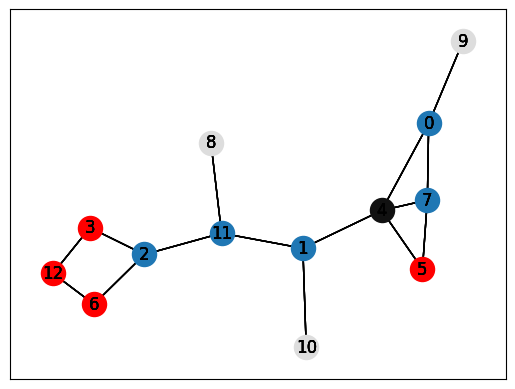

In [81]:
scatter_plot = MethFactory(graph_sampled, graph, '')

In [83]:
garbage = scatter_plot.illicit_drug

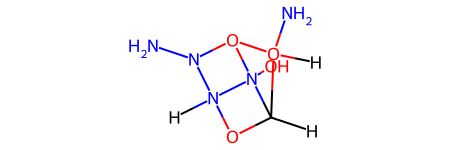

In [85]:
garbage

In [84]:
scatter_plot.valid_molecule()

True

In [86]:
scatter_plot.getSmiles()

'[H]C12ON3([H])N(N)O(N13O)O2([H])N'

In [90]:
Chem.Draw.MolToFile(scatter_plot.illicit_drug, f'genmols/sample1.png')  